In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-09-10 08:33:00.151662: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 08:33:00.220536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


2024-09-10 08:33:09.904774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 08:33:09.924047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 08:33:09.924340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# import argparse
# import h5py
# from sklearn.model_selection import train_test_split
# import numpy as np

# def create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57):
    
#     # read BACKGROUND data
#     with h5py.File(bkg_file, 'r') as file:
#         full_data = file['Particles'][:,:,:-1]
#         np.random.shuffle(full_data)
#         if events: full_data = full_data[:events,:,:]
    
#     # define training, test and validation datasets
#     X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
#     X_train, X_val = train_test_split(X_train, test_size=val_size)

#     del full_data
    
#     # flatten the data for model input
#     X_train = X_train.reshape(X_train.shape[0], input_shape)
#     X_test = X_test.reshape(X_test.shape[0], input_shape)
#     X_val = X_val.reshape(X_val.shape[0], input_shape)
    
#     with h5py.File(output_bkg_name + '_dataset.h5', 'w') as h5f:
#         h5f.create_dataset('X_train', data = X_train)
#         h5f.create_dataset('X_test', data = X_test)
#         h5f.create_dataset('X_val', data = X_val)
    
#     if signals_files:
#         # read SIGNAL data
#         for i, signal_file in enumerate(signals_files):
#             f = h5py.File(signal_file,'r')
#             signal_data = f['Particles'][:,:,:-1]
#             signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
#             with h5py.File(output_signal_names[i] + '_dataset.h5', 'w') as h5f2:
#                 h5f2.create_dataset('Data', data = signal_data)        
#     return
# bkg_file = "/eos/user/h/hjia/AnomalyDetection/40MHZ_data/background_for_training.h5"
# output_bkg_name = "SM_ZeroBias"

# create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names)

In [5]:
filename = "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/SM_ZeroBias_dataset.h5"
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [6]:
X_train = np.vstack((X_train, X_val))
print(X_train.shape)

(3200000, 57)


In [7]:
def scale_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")
    
    # Create a copy of the input array to avoid modifying the original
    scaled_arr = arr.copy()
    met_scale = 512
    em_scale = 128
    tau_scale = 128
    jet_scale = 256
    muon_scale = 32
    # Define the scaling factors for each column
    scale_dict = {
        0: 1/met_scale,
        3: 1/em_scale, 6: 1/em_scale, 9: 1/em_scale, 12: 1/em_scale, 15: 1/tau_scale,
        18: 1/tau_scale, 21: 1/tau_scale, 24: 1/tau_scale,
        27: 1/jet_scale, 30: 1/jet_scale, 33: 1/jet_scale, 36: 1/jet_scale, 39: 1/jet_scale, 42: 1/jet_scale,
        45: 1/muon_scale, 48: 1/muon_scale, 51: 1/muon_scale, 54: 1/muon_scale
    }

    # Apply scaling to the specified columns
    for col, scale_factor in scale_dict.items():
        scaled_arr[:, col] *= scale_factor
    
    return scaled_arr
X_train = scale_columns(X_train)
X_test = scale_columns(X_test)

In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [9]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: 0.0810
  Min: 0.0000
  Max: 2.2795
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0010
  Min: -3.1416
  Max: 3.1416
  Contains NaN: False

Column 4:
  Mean: 0.1598
  Min: 0.0000
  Max: 8.0595
  Contains NaN: False

Column 5:
  Mean: -0.0001
  Min: -3.0000
  Max: 3.0000
  Contains NaN: False

Column 6:
  Mean: 0.0005
  Min: -3.1416
  Max: 3.1416
  Contains NaN: False

Column 7:
  Mean: 0.0002
  Min: 0.0000
  Max: 1.2867
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -2.9988
  Max: 2.9989
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -3.1414
  Max: 3.1414
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.3428
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -2.9841
  Max: 2.9868
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -3.1366
  Max: 3.1340
  Contains NaN: False

Column 13:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.1266
  Contains NaN: Fals

In [10]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
#     x = LeakyReLU(alpha=1/1024, name="relu1")(x)
    x = LeakyReLU(alpha=1/1024, name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
    x = BatchNormalization(name="BN2")(x)
    x = LeakyReLU(alpha=1/1024, name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
    jet_scale = 256/64
    tau_scale = 128/64
    muon_scale = 32/64
    met_scale = 512/64
    em_scale = 128/64
#     jet_scale = 1
#     tau_scale = 1
#     muon_scale = 1
#     met_scale = 1
#     em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_sum(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        } 

In [11]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [14]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],32,16,3)
T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],32,16,3)
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
# T2A.set_beta(beta)
opt = keras.optimizers.Adam(learning_rate=0.001)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()


2024-09-07 01:40:28.832363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 01:40:28.832712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 01:40:28.832893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 57)]                 0         []                            
                                                                                                  
 BN0 (BatchNormalization)    (None, 57)                   228       ['input_1[0][0]']             
                                                                                                  
 dense1 (Dense)              (None, 32)                   1856      ['BN0[0][0]']                 
                                                                                                  
 BN1 (BatchNormalization)    (None, 32)                   128       ['dense1[0][0]']              
                                                                                            

In [14]:


early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]


tf.keras.backend.clear_session()
history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
T2A.save_weights(filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/', save_format='tf')

Epoch 1/100


2024-09-06 23:19:43.980859: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4983389240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-06 23:19:43.980936: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-06 23:19:43.991554: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 23:19:44.018766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-06 23:19:44.182343: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 38s 11ms/step - loss: 272.4374 - reco_loss: 271.6455 - kl_loss: 1.2085 - beta: 0.1563 - val_loss: 46.5927 - val_reco_loss: 45.2104 - val_kl_loss: 1.3823 - val_beta: 0.1563 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 27s 11ms/step - loss: 44.3649 - reco_loss: 42.9972 - kl_loss: 1.3087 - beta: 0.2127 - val_loss: 37.1081 - val_reco_loss: 35.8919 - val_kl_loss: 1.2163 - val_beta: 0.2127 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 27s 11ms/step - loss: 36.3183 - reco_loss: 35.0886 - kl_loss: 1.2503 - beta: 0.2689 - val_loss: 30.1624 - val_reco_loss: 28.8745 - val_kl_loss: 1.2879 - val_beta: 0.2689 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 27s 11ms/step - loss: 30.4323 - reco_loss: 29.1118 - kl_loss: 1.3502 - beta: 0.3249 - val_loss: 25.9808 - val_reco_loss: 24.5663 - val_kl_loss: 1.4145 - val_beta: 0.3249 - lr: 0.0010
Epoch 5/100
2500/2500 [===========================

In [13]:
for i in range(0,20):
    T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],32,16,3)
    T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],32,16,3)
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.7)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    T2A.save_weights(filepath='/eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_{}/'.format(i), save_format='tf')

2024-09-09 07:45:05.493993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 07:45:05.494342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 07:45:05.494515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-09-09 07:45:15.315454: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0f373893e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-09 07:45:15.315527: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-09 07:45:15.327453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-09 07:45:15.361307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-09 07:45:15.550854: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 39s 12ms/step - loss: 203.4375 - reco_loss: 202.2538 - kl_loss: 1.4603 - beta: 0.1484 - val_loss: 45.2811 - val_reco_loss: 44.1179 - val_kl_loss: 1.1632 - val_beta: 0.1484 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 27s 11ms/step - loss: 43.8987 - reco_loss: 42.7930 - kl_loss: 1.0587 - beta: 0.1967 - val_loss: 32.8794 - val_reco_loss: 31.8576 - val_kl_loss: 1.0218 - val_beta: 0.1967 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 27s 11ms/step - loss: 32.9046 - reco_loss: 31.8620 - kl_loss: 1.0551 - beta: 0.2449 - val_loss: 27.1441 - val_reco_loss: 26.0580 - val_kl_loss: 1.0861 - val_beta: 0.2449 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 27s 11ms/step - loss: 28.1773 - reco_loss: 27.0615 - kl_loss: 1.1461 - beta: 0.2929 - val_loss: 24.7197 - val_reco_loss: 23.5146 - val_kl_loss: 1.2051 - val_beta: 0.2929 - lr: 0.0010
Epoch 5/100
2500/2500 [===========================

2500/2500 [==============================] - 27s 11ms/step - loss: 25.0264 - reco_loss: 24.5483 - kl_loss: 0.5307 - beta: 0.1485 - val_loss: 23.8247 - val_reco_loss: 23.1993 - val_kl_loss: 0.6255 - val_beta: 0.1485 - lr: 5.0000e-04
Epoch 27/100
2500/2500 [==============================] - 27s 11ms/step - loss: 23.6593 - reco_loss: 22.9920 - kl_loss: 0.7095 - beta: 0.1965 - val_loss: 22.4815 - val_reco_loss: 21.6929 - val_kl_loss: 0.7885 - val_beta: 0.1965 - lr: 5.0000e-04
Epoch 28/100
2500/2500 [==============================] - 27s 11ms/step - loss: 22.5229 - reco_loss: 21.6899 - kl_loss: 0.8745 - beta: 0.2445 - val_loss: 21.4822 - val_reco_loss: 20.5299 - val_kl_loss: 0.9523 - val_beta: 0.2445 - lr: 5.0000e-04
Epoch 29/100
2500/2500 [==============================] - 28s 11ms/step - loss: 21.3300 - reco_loss: 20.3345 - kl_loss: 1.0340 - beta: 0.2925 - val_loss: 19.9826 - val_reco_loss: 18.8695 - val_kl_loss: 1.1131 - val_beta: 0.2925 - lr: 5.0000e-04
Epoch 30/100
2500/2500 [=========

2500/2500 [==============================] - 28s 11ms/step - loss: 22.0587 - reco_loss: 20.6356 - kl_loss: 1.4572 - beta: 0.4130 - val_loss: 18.7612 - val_reco_loss: 17.2258 - val_kl_loss: 1.5354 - val_beta: 0.4130 - lr: 0.0010
Epoch 20/100
2500/2500 [==============================] - 27s 11ms/step - loss: 20.5174 - reco_loss: 18.9595 - kl_loss: 1.5904 - beta: 0.4610 - val_loss: 17.6342 - val_reco_loss: 15.9711 - val_kl_loss: 1.6630 - val_beta: 0.4610 - lr: 0.0010
Epoch 21/100
2500/2500 [==============================] - 28s 11ms/step - loss: 19.1943 - reco_loss: 17.5146 - kl_loss: 1.7085 - beta: 0.5090 - val_loss: 16.0803 - val_reco_loss: 14.3002 - val_kl_loss: 1.7800 - val_beta: 0.5090 - lr: 0.0010
Epoch 22/100
2499/2500 [============================>.] - ETA: 0s - loss: 17.7131 - reco_loss: 15.9208 - kl_loss: 1.8162 - beta: 0.5570
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2500/2500 [==============================] - 27s 11ms/step - loss: 17.7128 - 

2500/2500 [==============================] - 27s 11ms/step - loss: 36.3270 - reco_loss: 35.3345 - kl_loss: 1.0254 - beta: 0.2449 - val_loss: 30.6112 - val_reco_loss: 29.4980 - val_kl_loss: 1.1132 - val_beta: 0.2449 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 27s 11ms/step - loss: 30.5262 - reco_loss: 29.3824 - kl_loss: 1.1831 - beta: 0.2930 - val_loss: 26.0875 - val_reco_loss: 24.8173 - val_kl_loss: 1.2702 - val_beta: 0.2930 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 27s 11ms/step - loss: 26.8198 - reco_loss: 25.5171 - kl_loss: 1.3415 - beta: 0.3410 - val_loss: 24.0351 - val_reco_loss: 22.6365 - val_kl_loss: 1.3986 - val_beta: 0.3410 - lr: 0.0010
Epoch 6/100
2500/2500 [==============================] - 27s 11ms/step - loss: 24.5944 - reco_loss: 23.1486 - kl_loss: 1.4814 - beta: 0.3890 - val_loss: 22.0690 - val_reco_loss: 20.5139 - val_kl_loss: 1.5551 - val_beta: 0.3890 - lr: 0.0010
Epoch 7/100
2500/2500 [=============================

Epoch 36/100
2500/2500 [==============================] - 27s 11ms/step - loss: 13.2900 - reco_loss: 11.3660 - kl_loss: 1.9441 - beta: 0.6282 - val_loss: 12.0368 - val_reco_loss: 10.0570 - val_kl_loss: 1.9798 - val_beta: 0.6282 - lr: 2.5000e-04
Epoch 37/100
2500/2500 [==============================] - 27s 11ms/step - loss: 12.0895 - reco_loss: 10.0834 - kl_loss: 2.0190 - beta: 0.6762 - val_loss: 10.9179 - val_reco_loss: 8.8855 - val_kl_loss: 2.0324 - val_beta: 0.6762 - lr: 2.5000e-04
Epoch 38/100
2500/2500 [==============================] - 27s 11ms/step - loss: 13.1051 - reco_loss: 11.2976 - kl_loss: 1.2692 - beta: 0.1242 - val_loss: 23.7925 - val_reco_loss: 23.2504 - val_kl_loss: 0.5421 - val_beta: 0.1242 - lr: 2.5000e-04
Epoch 39/100
2500/2500 [==============================] - 28s 11ms/step - loss: 24.1650 - reco_loss: 23.5714 - kl_loss: 0.6384 - beta: 0.1722 - val_loss: 21.9263 - val_reco_loss: 21.2029 - val_kl_loss: 0.7234 - val_beta: 0.1722 - lr: 2.5000e-04
Epoch 40/100
2500/250

2500/2500 [==============================] - 27s 11ms/step - loss: 21.4227 - reco_loss: 20.4048 - kl_loss: 1.0583 - beta: 0.2925 - val_loss: 19.4017 - val_reco_loss: 18.2664 - val_kl_loss: 1.1353 - val_beta: 0.2925 - lr: 5.0000e-04
Epoch 30/100
2500/2500 [==============================] - 27s 11ms/step - loss: 20.2514 - reco_loss: 19.0752 - kl_loss: 1.2138 - beta: 0.3405 - val_loss: 18.5091 - val_reco_loss: 17.2208 - val_kl_loss: 1.2883 - val_beta: 0.3405 - lr: 5.0000e-04
Epoch 31/100
2500/2500 [==============================] - 27s 11ms/step - loss: 19.0888 - reco_loss: 17.7688 - kl_loss: 1.3535 - beta: 0.3885 - val_loss: 17.3494 - val_reco_loss: 15.9189 - val_kl_loss: 1.4304 - val_beta: 0.3885 - lr: 5.0000e-04
Epoch 32/100
2500/2500 [==============================] - 28s 11ms/step - loss: 17.9131 - reco_loss: 16.4588 - kl_loss: 1.4853 - beta: 0.4365 - val_loss: 16.2539 - val_reco_loss: 14.7013 - val_kl_loss: 1.5526 - val_beta: 0.4365 - lr: 5.0000e-04
Epoch 33/100
2500/2500 [=========

Epoch 61/100
2500/2500 [==============================] - 27s 11ms/step - loss: 12.6023 - reco_loss: 10.6976 - kl_loss: 1.9280 - beta: 0.6280 - val_loss: 11.0212 - val_reco_loss: 9.0514 - val_kl_loss: 1.9698 - val_beta: 0.6280 - lr: 6.2500e-05
Epoch 62/100
2500/2500 [==============================] - 27s 11ms/step - loss: 11.4517 - reco_loss: 9.4596 - kl_loss: 2.0114 - beta: 0.6760 - val_loss: 10.0155 - val_reco_loss: 7.9705 - val_kl_loss: 2.0450 - val_beta: 0.6760 - lr: 6.2500e-05
Epoch 63/100
2500/2500 [==============================] - 27s 11ms/step - loss: 12.4032 - reco_loss: 10.5993 - kl_loss: 1.2525 - beta: 0.1240 - val_loss: 21.0868 - val_reco_loss: 20.5654 - val_kl_loss: 0.5214 - val_beta: 0.1240 - lr: 6.2500e-05
Epoch 64/100
2500/2500 [==============================] - 27s 11ms/step - loss: 22.6063 - reco_loss: 22.0242 - kl_loss: 0.6340 - beta: 0.1720 - val_loss: 20.1860 - val_reco_loss: 19.4606 - val_kl_loss: 0.7254 - val_beta: 0.1720 - lr: 6.2500e-05
Epoch 65/100
2500/2500 

2500/2500 [==============================] - 27s 11ms/step - loss: 23.0194 - reco_loss: 21.9808 - kl_loss: 1.0784 - beta: 0.2925 - val_loss: 20.7876 - val_reco_loss: 19.6278 - val_kl_loss: 1.1598 - val_beta: 0.2925 - lr: 5.0000e-04
Epoch 30/100
2500/2500 [==============================] - 27s 11ms/step - loss: 21.7718 - reco_loss: 20.5752 - kl_loss: 1.2344 - beta: 0.3405 - val_loss: 19.4449 - val_reco_loss: 18.1330 - val_kl_loss: 1.3120 - val_beta: 0.3405 - lr: 5.0000e-04
Epoch 31/100
2500/2500 [==============================] - 28s 11ms/step - loss: 20.4269 - reco_loss: 19.0832 - kl_loss: 1.3789 - beta: 0.3885 - val_loss: 18.2704 - val_reco_loss: 16.8170 - val_kl_loss: 1.4534 - val_beta: 0.3885 - lr: 5.0000e-04
Epoch 32/100
2500/2500 [==============================] - 27s 11ms/step - loss: 19.1212 - reco_loss: 17.6417 - kl_loss: 1.5132 - beta: 0.4365 - val_loss: 17.1065 - val_reco_loss: 15.5213 - val_kl_loss: 1.5852 - val_beta: 0.4365 - lr: 5.0000e-04
Epoch 33/100
2500/2500 [=========

2499/2500 [============================>.] - ETA: 0s - loss: 16.6360 - reco_loss: 14.9692 - kl_loss: 1.6933 - beta: 0.5569
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2500/2500 [==============================] - 27s 11ms/step - loss: 16.6357 - reco_loss: 14.9688 - kl_loss: 1.6933 - beta: 0.5570 - val_loss: 14.5666 - val_reco_loss: 12.7970 - val_kl_loss: 1.7695 - val_beta: 0.5570 - lr: 0.0010
Epoch 23/100
2500/2500 [==============================] - 28s 11ms/step - loss: 14.9953 - reco_loss: 13.2403 - kl_loss: 1.7773 - beta: 0.6045 - val_loss: 13.5350 - val_reco_loss: 11.7055 - val_kl_loss: 1.8296 - val_beta: 0.6045 - lr: 5.0000e-04
Epoch 24/100
2500/2500 [==============================] - 28s 11ms/step - loss: 13.6124 - reco_loss: 11.7734 - kl_loss: 1.8600 - beta: 0.6525 - val_loss: 12.5753 - val_reco_loss: 10.6808 - val_kl_loss: 1.8945 - val_beta: 0.6525 - lr: 5.0000e-04
Epoch 25/100
2500/2500 [==============================] - 28s 11ms/step - loss: 12

2500/2500 [==============================] - 28s 11ms/step - loss: 25.1378 - reco_loss: 23.7814 - kl_loss: 1.3874 - beta: 0.3890 - val_loss: 21.9030 - val_reco_loss: 20.4529 - val_kl_loss: 1.4501 - val_beta: 0.3890 - lr: 0.0010
Epoch 7/100
2500/2500 [==============================] - 28s 11ms/step - loss: 22.6589 - reco_loss: 21.1816 - kl_loss: 1.5083 - beta: 0.4370 - val_loss: 19.9286 - val_reco_loss: 18.3602 - val_kl_loss: 1.5684 - val_beta: 0.4370 - lr: 0.0010
Epoch 8/100
2500/2500 [==============================] - 28s 11ms/step - loss: 20.4916 - reco_loss: 18.8923 - kl_loss: 1.6286 - beta: 0.4850 - val_loss: 18.2662 - val_reco_loss: 16.5844 - val_kl_loss: 1.6818 - val_beta: 0.4850 - lr: 0.0010
Epoch 9/100
2500/2500 [==============================] - 28s 11ms/step - loss: 18.6293 - reco_loss: 16.9132 - kl_loss: 1.7434 - beta: 0.5329 - val_loss: 16.4880 - val_reco_loss: 14.6892 - val_kl_loss: 1.7988 - val_beta: 0.5329 - lr: 0.0010
Epoch 10/100
2500/2500 [============================

2500/2500 [==============================] - 28s 11ms/step - loss: 20.7308 - reco_loss: 19.3496 - kl_loss: 1.4148 - beta: 0.3885 - val_loss: 19.2727 - val_reco_loss: 17.7864 - val_kl_loss: 1.4863 - val_beta: 0.3885 - lr: 5.0000e-04
Epoch 32/100
2500/2500 [==============================] - 28s 11ms/step - loss: 19.3404 - reco_loss: 17.8197 - kl_loss: 1.5547 - beta: 0.4365 - val_loss: 17.8664 - val_reco_loss: 16.2378 - val_kl_loss: 1.6287 - val_beta: 0.4365 - lr: 5.0000e-04
Epoch 33/100
2500/2500 [==============================] - 29s 12ms/step - loss: 17.9632 - reco_loss: 16.3221 - kl_loss: 1.6696 - beta: 0.4845 - val_loss: 16.7504 - val_reco_loss: 15.0251 - val_kl_loss: 1.7253 - val_beta: 0.4845 - lr: 5.0000e-04
Epoch 34/100
2500/2500 [==============================] - 28s 11ms/step - loss: 16.6209 - reco_loss: 14.8713 - kl_loss: 1.7766 - beta: 0.5325 - val_loss: 15.3552 - val_reco_loss: 13.5347 - val_kl_loss: 1.8205 - val_beta: 0.5325 - lr: 5.0000e-04
Epoch 35/100
2498/2500 [=========

Epoch 16/100
2500/2500 [==============================] - 28s 11ms/step - loss: 23.6413 - reco_loss: 22.6662 - kl_loss: 1.0174 - beta: 0.2690 - val_loss: 20.7102 - val_reco_loss: 19.6048 - val_kl_loss: 1.1054 - val_beta: 0.2690 - lr: 0.0010
Epoch 17/100
2500/2500 [==============================] - 28s 11ms/step - loss: 22.2174 - reco_loss: 21.0718 - kl_loss: 1.1854 - beta: 0.3170 - val_loss: 19.2445 - val_reco_loss: 17.9748 - val_kl_loss: 1.2697 - val_beta: 0.3170 - lr: 0.0010
Epoch 18/100
2500/2500 [==============================] - 28s 11ms/step - loss: 20.8277 - reco_loss: 19.5230 - kl_loss: 1.3426 - beta: 0.3650 - val_loss: 18.0176 - val_reco_loss: 16.6024 - val_kl_loss: 1.4152 - val_beta: 0.3650 - lr: 0.0010
Epoch 19/100
2500/2500 [==============================] - 28s 11ms/step - loss: 19.5980 - reco_loss: 18.1471 - kl_loss: 1.4860 - beta: 0.4130 - val_loss: 16.9360 - val_reco_loss: 15.3865 - val_kl_loss: 1.5495 - val_beta: 0.4130 - lr: 0.0010
Epoch 20/100
2500/2500 [============

2500/2500 [==============================] - 28s 11ms/step - loss: 25.1529 - reco_loss: 24.4314 - kl_loss: 0.7615 - beta: 0.2202 - val_loss: 23.1907 - val_reco_loss: 22.3434 - val_kl_loss: 0.8473 - val_beta: 0.2202 - lr: 2.5000e-04
Epoch 1/100
2500/2500 [==============================] - 41s 13ms/step - loss: 288.1661 - reco_loss: 287.3794 - kl_loss: 1.1789 - beta: 0.1483 - val_loss: 51.1212 - val_reco_loss: 49.8833 - val_kl_loss: 1.2379 - val_beta: 0.1483 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 28s 11ms/step - loss: 48.8387 - reco_loss: 47.7143 - kl_loss: 1.0735 - beta: 0.1967 - val_loss: 39.3587 - val_reco_loss: 38.3221 - val_kl_loss: 1.0366 - val_beta: 0.1967 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 29s 12ms/step - loss: 38.9418 - reco_loss: 37.9203 - kl_loss: 1.0407 - beta: 0.2449 - val_loss: 30.9456 - val_reco_loss: 29.8425 - val_kl_loss: 1.1032 - val_beta: 0.2449 - lr: 0.0010
Epoch 4/100
2500/2500 [=======================

2500/2500 [==============================] - 30s 12ms/step - loss: 12.2374 - reco_loss: 10.3191 - kl_loss: 1.9339 - beta: 0.7005 - val_loss: 11.2576 - val_reco_loss: 9.2858 - val_kl_loss: 1.9717 - val_beta: 0.7005 - lr: 5.0000e-04
Epoch 26/100
2500/2500 [==============================] - 30s 12ms/step - loss: 27.0508 - reco_loss: 26.5754 - kl_loss: 0.5269 - beta: 0.1485 - val_loss: 25.9568 - val_reco_loss: 25.3422 - val_kl_loss: 0.6146 - val_beta: 0.1485 - lr: 5.0000e-04
Epoch 27/100
2500/2500 [==============================] - 29s 12ms/step - loss: 25.7071 - reco_loss: 25.0461 - kl_loss: 0.7051 - beta: 0.1965 - val_loss: 24.9745 - val_reco_loss: 24.1829 - val_kl_loss: 0.7917 - val_beta: 0.1965 - lr: 5.0000e-04
Epoch 28/100
2500/2500 [==============================] - 30s 12ms/step - loss: 24.5523 - reco_loss: 23.7210 - kl_loss: 0.8712 - beta: 0.2445 - val_loss: 23.3878 - val_reco_loss: 22.4347 - val_kl_loss: 0.9531 - val_beta: 0.2445 - lr: 5.0000e-04
Epoch 29/100
2500/2500 [==========

Epoch 18/100
2500/2500 [==============================] - 28s 11ms/step - loss: 22.1420 - reco_loss: 20.8951 - kl_loss: 1.2824 - beta: 0.3650 - val_loss: 20.5784 - val_reco_loss: 19.2179 - val_kl_loss: 1.3605 - val_beta: 0.3650 - lr: 0.0010
Epoch 19/100
2500/2500 [==============================] - 28s 11ms/step - loss: 20.6375 - reco_loss: 19.2506 - kl_loss: 1.4203 - beta: 0.4130 - val_loss: 19.5548 - val_reco_loss: 18.0685 - val_kl_loss: 1.4863 - val_beta: 0.4130 - lr: 0.0010
Epoch 20/100
2500/2500 [==============================] - 28s 11ms/step - loss: 19.2239 - reco_loss: 17.7099 - kl_loss: 1.5441 - beta: 0.4610 - val_loss: 17.8103 - val_reco_loss: 16.2130 - val_kl_loss: 1.5973 - val_beta: 0.4610 - lr: 0.0010
Epoch 21/100
2500/2500 [==============================] - 28s 11ms/step - loss: 17.8599 - reco_loss: 16.2337 - kl_loss: 1.6545 - beta: 0.5090 - val_loss: 16.2592 - val_reco_loss: 14.5473 - val_kl_loss: 1.7119 - val_beta: 0.5090 - lr: 0.0010
Epoch 22/100
2496/2500 [============

2500/2500 [==============================] - 28s 11ms/step - loss: 49.1550 - reco_loss: 47.8431 - kl_loss: 1.2385 - beta: 0.1966 - val_loss: 38.7216 - val_reco_loss: 37.5726 - val_kl_loss: 1.1490 - val_beta: 0.1966 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 28s 11ms/step - loss: 38.1749 - reco_loss: 37.0461 - kl_loss: 1.1242 - beta: 0.2448 - val_loss: 30.6298 - val_reco_loss: 29.4751 - val_kl_loss: 1.1547 - val_beta: 0.2448 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 28s 11ms/step - loss: 31.9565 - reco_loss: 30.7726 - kl_loss: 1.2193 - beta: 0.2930 - val_loss: 26.5443 - val_reco_loss: 25.2478 - val_kl_loss: 1.2965 - val_beta: 0.2930 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 28s 11ms/step - loss: 28.1840 - reco_loss: 26.8619 - kl_loss: 1.3534 - beta: 0.3410 - val_loss: 24.1914 - val_reco_loss: 22.7628 - val_kl_loss: 1.4286 - val_beta: 0.3410 - lr: 0.0010
Epoch 6/100
2500/2500 [=============================

2496/2500 [============================>.] - ETA: 0s - loss: 15.5901 - reco_loss: 13.6406 - kl_loss: 1.9746 - beta: 0.5804
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2500/2500 [==============================] - 28s 11ms/step - loss: 15.5894 - reco_loss: 13.6398 - kl_loss: 1.9746 - beta: 0.5805 - val_loss: 14.0026 - val_reco_loss: 11.9658 - val_kl_loss: 2.0367 - val_beta: 0.5805 - lr: 5.0000e-04
Epoch 36/100
2500/2500 [==============================] - 28s 11ms/step - loss: 14.1596 - reco_loss: 12.1156 - kl_loss: 2.0667 - beta: 0.6282 - val_loss: 12.5211 - val_reco_loss: 10.4032 - val_kl_loss: 2.1179 - val_beta: 0.6282 - lr: 2.5000e-04
Epoch 37/100
2500/2500 [==============================] - 28s 11ms/step - loss: 12.8437 - reco_loss: 10.7036 - kl_loss: 2.1646 - beta: 0.6762 - val_loss: 11.2301 - val_reco_loss: 9.0171 - val_kl_loss: 2.2130 - val_beta: 0.6762 - lr: 2.5000e-04
Epoch 38/100
2500/2500 [==============================] - 28s 11ms/step - loss:

2500/2500 [==============================] - 28s 11ms/step - loss: 16.8674 - reco_loss: 15.2743 - kl_loss: 1.6179 - beta: 0.5325 - val_loss: 15.5285 - val_reco_loss: 13.8599 - val_kl_loss: 1.6685 - val_beta: 0.5325 - lr: 5.0000e-04
Epoch 35/100
2499/2500 [============================>.] - ETA: 0s - loss: 15.4725 - reco_loss: 13.7826 - kl_loss: 1.7131 - beta: 0.5805
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2500/2500 [==============================] - 28s 11ms/step - loss: 15.4723 - reco_loss: 13.7823 - kl_loss: 1.7131 - beta: 0.5805 - val_loss: 14.1933 - val_reco_loss: 12.4401 - val_kl_loss: 1.7532 - val_beta: 0.5805 - lr: 5.0000e-04
Epoch 36/100
2500/2500 [==============================] - 28s 11ms/step - loss: 14.1629 - reco_loss: 12.3843 - kl_loss: 1.7971 - beta: 0.6282 - val_loss: 12.8802 - val_reco_loss: 11.0609 - val_kl_loss: 1.8194 - val_beta: 0.6282 - lr: 2.5000e-04
Epoch 37/100
2500/2500 [==============================] - 28s 11ms/step - loss

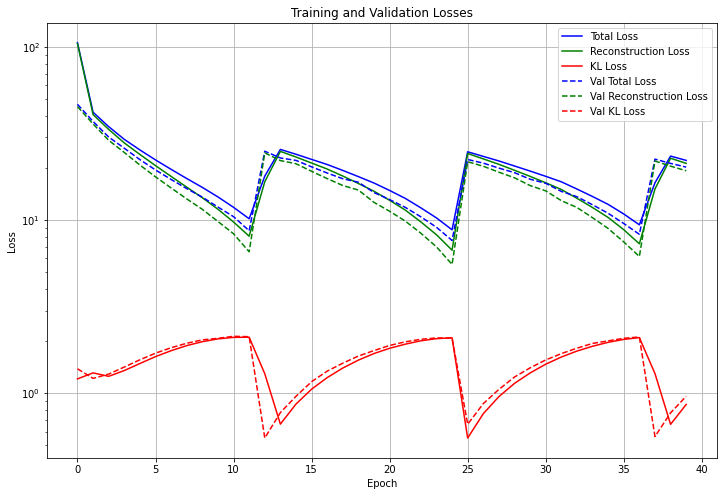

In [15]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [13]:
signals_file = ["/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/Ato4l_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hToTauTau_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hChToTauNu_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/leptoquark_dataset.h5"]
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [14]:
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
#         test_data = np.array(scaler.transform(file['Data']))
        test_data = scale_columns(np.array(file['Data']))
    signal_data.append(test_data)

In [15]:
from scipy import stats

def total_loss(signal, predict, z_mean, z_log_var, beta):
    re_loss = np.mean((signal - predict) ** 2)
    kl_loss = np.sum(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    tot_loss = re_loss + beta * kl_loss
    return tot_loss

def AD_score(s, p, z_m, z_log, beta):
    mask = s != 0

    _s = s * mask
    _p = p * mask

    p = mask * p
    return total_loss(_s, _p, z_m, z_log, beta)


def AD_score_MSE(s, p):
    mask = s != 0
    s1 = s * mask
    p1 = p * mask
    re_loss = np.mean((s1 - p1) ** 2)
    return re_loss


def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss


def AD_score_Rz(z_mean, z_log_var):
    Rz_loss = np.mean((z_mean**2) / (np.exp(z_log_var)))
    return Rz_loss


def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL


class Model_Evaluator:
    def __init__(
        self,
        model_path,
        backround,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        #vae_enc = make_encoder_set_weights(input_dim, 32,16,3)
        #vae_dec = make_decoder_set_weights(input_dim, 32,16,3)
        vae_enc = Qmake_encoder_set_weights(input_dim, 32,16,3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32,16,3)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.backround = backround
        self.br_loss = []
        self.signal_loss = []
        self.backround_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.backround

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]        

        if l_type == "MSE":
            br_predict = np.array(self.model.predict(br)["reconstruction"])
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_MSE(br[i], br_predict[i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_predict = np.array(self.model.predict(batch)["reconstruction"])
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_MSE(batch[i], sg_predict[i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        return [self.br_loss, self.signal_loss]

    def histogram(self, bins):
        plt.hist(
            self.br_loss,
            weights=self.br_weights,
            bins=bins,
            histtype="step",
            label="backround num_events:{}".format(len(self.br_loss)),
        )
        for i, batch in enumerate(self.signal_loss):
            plt.hist(
                batch,
                weights=self.signal_weights[i],
                bins=bins,
                histtype="step",
                label=str(self.labels[i]) + " num_events:{}".format(len(batch)),
            )
        plt.xlabel("loss")
        plt.ylabel("Frequency")
        plt.yscale("log")
        plt.title("{}_Hist".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def ROC(self):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])


        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Theshold = {threshold:.6f}")


    def GetPerformance(self):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr:.6f}")

        print(f"Number of results: {len(results)}")
        return results

    def weighted_S_F(self, rate1):
        sf_list = []
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            saved = 0
            saved_index = 0
            for k, f in enumerate(fpr):
                if f > saved and f <= rate1:
                    saved = f
                    saved_index = k
            sf_list += [tpr[saved_index]]
        return sf_list



    def SIC(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / np.sqrt(fpr), label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/sqrt(fpr)")
        plt.title("{}_SIC".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def Sensitivity(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            print("NaNs in ROC_data:", np.isnan(ROC_data).any())
            print("NaNs in truth:", np.isnan(truth).any())
            if weights is not None:
                print("NaNs in weights:", np.isnan(weights).any())
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / fpr, label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/fpr")
        # plt.semilogy()
        plt.title("{}_Sensitivity".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def S_F(self, true_br_rate, desired_br_rate):
        N = len(self.br_loss)
        n = int(np.round(N * (desired_br_rate / true_br_rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        print(AD)
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        return self.signal_sensitivity

    def Find_AD_Cutoff(self, br_rate, desired_rate, starting_AD):
        N = self.backround.shape[0]
        AD_max = starting_AD
        AD_List = np.linspace(0, AD_max, num=1000)
        best_AD = 0
        for i, AD in enumerate(np.flip(AD_List)):
            n = 0
            for loss in self.br_loss:
                if loss >= AD:
                    n += 1
            sigrate = br_rate * n / N
            if sigrate <= desired_rate:
                best_AD = AD
            if sigrate > desired_rate:
                break
        self.AD_cutoff = best_AD
        return best_AD

    def calculate_sensitivity(self, br_rate):
        AD = self.AD_cutoff
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        print(self.signal_sensitivity)

    def event_anomally_checker(self, rate):
        N = len(self.br_loss)
        n = int(np.round(N * (rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        sensitivity = []
        anomalous_events = []
        for i, losses in enumerate(self.signal_loss):
            anomalous_signs = []
            for i, loss in enumerate(losses):
                if loss >= AD:
                    anomalous_signs += [i]
            anomalous_events += [anomalous_signs]
        return anomalous_events

    def pt_correlation(self):
        pt_num = self.input_dim // 3
        print(pt_num)
        for k, sig in enumerate(self.signal):
            tot_pt_per_event = []
            for event in sig:
                pt = 0
                for i in range(0, pt_num):
                    pt += event[3 * i]
                tot_pt_per_event += [pt]
            plt.hist2d(
                tot_pt_per_event,
                self.signal_loss[k],
                cmin=1,
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                weights=self.signal_weights[k],
                norm="log",
            )
            # plt.semilogx()
            plt.xlabel("event pt")
            plt.ylabel("anomaly score")
            # plt.semilogy()
            # plt.hist(tot_pt_per_event)
            # plt.show()
            plt.colorbar()
            plt.show()
            plt.scatter(tot_pt_per_event, self.signal_loss[k])
            plt.show()

    def met_correlation(self, br_MET, signal_METs):

        plt.hist2d(
            br_MET,
            self.br_loss,
            bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
            cmin=1,
            weights=self.br_weights,
            norm="log",
        )
        plt.semilogx()
        plt.xlabel("MET pt")
        plt.ylabel("anomaly score")
        plt.semilogy()
        plt.colorbar()
        plt.title(self.title + " backround")
        plt.show()
        for i, list in enumerate(signal_METs):

            plt.hist2d(
                list,
                self.signal_loss[i],
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                cmin=1,
                weights=self.signal_weights[i],
                norm="log",
            )
            plt.semilogx()
            plt.xlabel("MET pt")
            plt.ylabel("anomaly score")
            plt.semilogy()
            plt.colorbar()
            plt.title(self.title + " " + self.labels[i])
            plt.show()

    def plot_anomaly_score_distribution(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        bins = 10000
        # Determine the range for the bins
        all_scores = np.concatenate([self.br_loss] + self.signal_loss)
        min_score, max_score = 0.01, np.max(all_scores)
        bin_edges = np.linspace(min_score, max_score, bins + 1)

        # Plot background distribution
        br_weights = self.br_weights / np.sum(self.br_weights)  # Normalize weights
        counts, _, _ = ax.hist(self.br_loss, bins=bin_edges, weights=br_weights, 
                               histtype='step', label='Background',
                               color='black', density=True, linewidth=3)

        # Plot signal distributions
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.signal_loss)))
        for i, (signal_scores, signal_weights, label) in enumerate(zip(self.signal_loss, self.signal_weights, self.labels)):
            signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
            ax.hist(signal_scores, bins=bin_edges, weights=signal_weights,
                    histtype='step', label=label, color=colors[i],
                    density=True, linewidth=2)

        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Density')
        ax.set_title(f'{self.title} Anomaly Score Distribution')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.7)

        ax.set_ylim(bottom=1e-4, top=10)

        ax.set_xscale('log')
        ax.set_yscale('log')

        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_Anomaly_Score_Distribution_Histogram.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        # Calculate and print the mean anomaly score for each distribution
        print("\nMean Anomaly Scores:")
        print(f"Background: {np.average(self.br_loss, weights=self.br_weights):.6f}")
        for signal_scores, signal_weights, label in zip(self.signal_loss, self.signal_weights, self.labels):
            mean_score = np.average(signal_scores, weights=signal_weights)
            print(f"{label}: {mean_score:.6f}")

            

In [16]:
def read_h5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
#             data = scaler.transform(f['Data'])
            data =  scale_columns(np.array(f['Data']))
        return data
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None
Ato4l_data = read_h5_data(signals_file[0])
hToTauTau_data = read_h5_data(signals_file[1])
hChToTauNu_data = read_h5_data(signals_file[2])
leptoquark_data = read_h5_data(signals_file[3])

In [17]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs = keras.Input(shape=(input_dim), name = "inputs")
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
            name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
    x = LeakyReLU(alpha=1/1024, name = 'relu1')(x)
    x = Dense(h_dim_2,
            name = "dense2")(x)
    x = BatchNormalization(name="BN2")(x)
    x = LeakyReLU(alpha=1/1024, name = 'relu2')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_logvar = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs = keras.Input(shape=(latent_dim))
    x = layers.Dense(h_dim_2, activation='relu')(inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    z = layers.Dense(input_dim)(x)
    decoder = keras.Model(inputs,z,name='decoder')
    return decoder

class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        #KL loss changed abck to sum as in paper
        #kl_loss = tf.reduce_sum(kl_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_0/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
trut

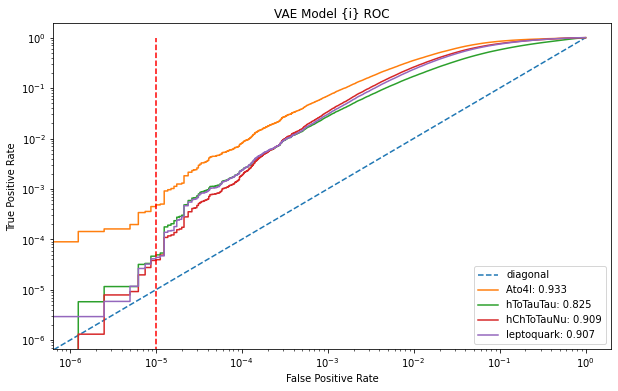


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000447
hToTauTau: 0.000046
hChToTauNu: 0.000038
leptoquark: 0.000041
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00044667583841054867), ('hToTauTau', 4.629073765737043e-05), ('hChToTauNu', 3.814424311299114e-05), ('leptoquark', 4.1110693478669425e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_1/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1

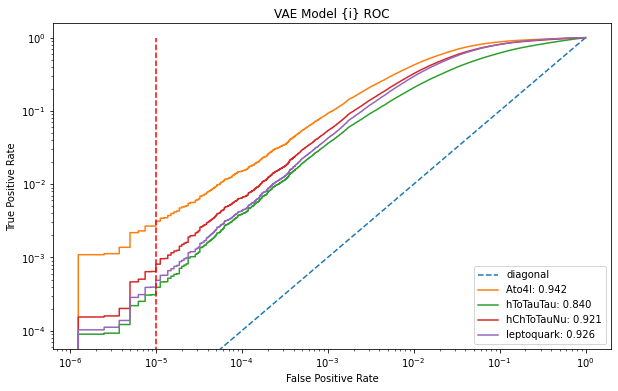


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002680
hToTauTau: 0.000310
hChToTauNu: 0.000643
leptoquark: 0.000393
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0026800550304632922), ('hToTauTau', 0.00030956930808366474), ('hChToTauNu', 0.0006431908580087127), ('leptoquark', 0.00039348806615297876)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_2/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1

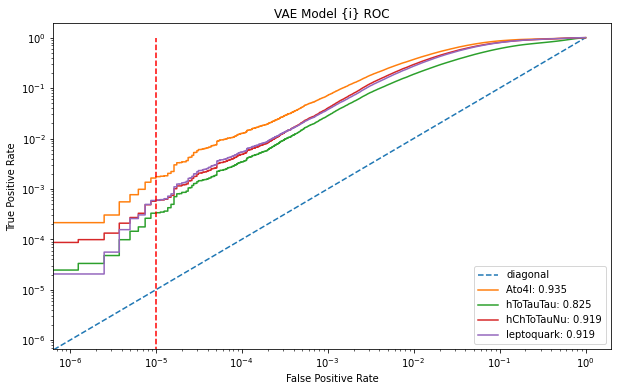


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001644
hToTauTau: 0.000330
hChToTauNu: 0.000570
leptoquark: 0.000590
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0016437670853508193), ('hToTauTau', 0.0003298215058087643), ('hChToTauNu', 0.0005695330092387987), ('leptoquark', 0.0005902320992294682)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_3/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (149

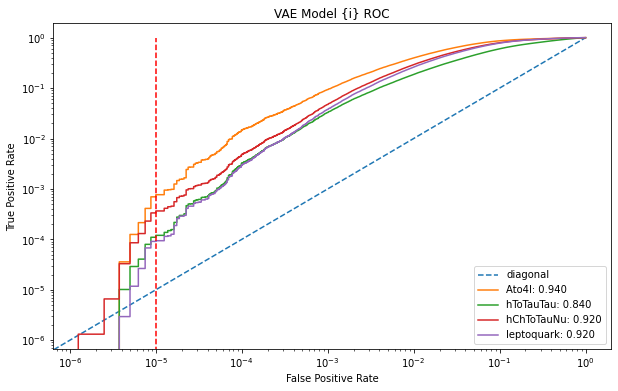


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000697
hToTauTau: 0.000110
hChToTauNu: 0.000334
leptoquark: 0.000091
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.000696814307920456), ('hToTauTau', 0.00010994050193625476), ('hChToTauNu', 0.00033409095692068104), ('leptoquark', 9.103082127419659e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_4/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

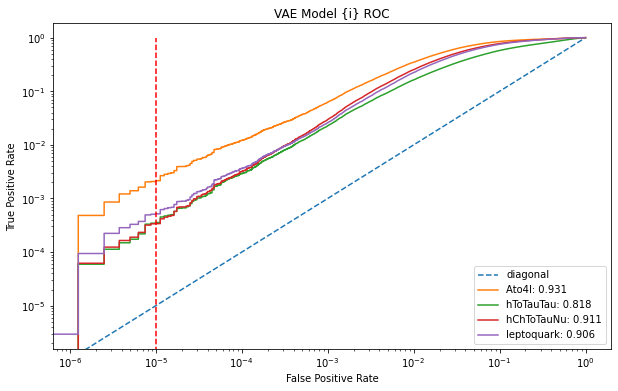


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002073
hToTauTau: 0.000346
hChToTauNu: 0.000337
leptoquark: 0.000508
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.002072575890224946), ('hToTauTau', 0.0003457339468784854), ('hChToTauNu', 0.0003367215943767494), ('leptoquark', 0.0005080107122721293)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_5/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491

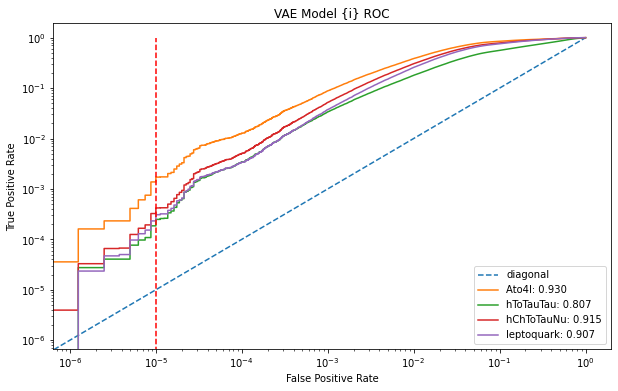


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001376
hToTauTau: 0.000185
hChToTauNu: 0.000325
leptoquark: 0.000232
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00137576158230449), ('hToTauTau', 0.0001851629506294817), ('hChToTauNu', 0.00032488372582444177), ('leptoquark', 0.00023198177034392033)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_6/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (149

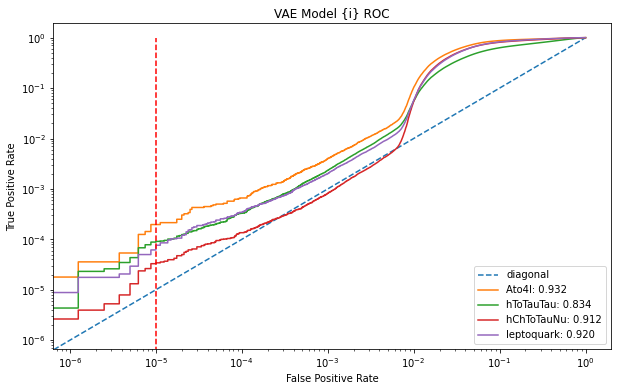


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000197
hToTauTau: 0.000088
hChToTauNu: 0.000033
leptoquark: 0.000062
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00019653736890064142), ('hToTauTau', 8.824171865936238e-05), ('hChToTauNu', 3.288296820085443e-05), ('leptoquark', 6.166604021800414e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_7/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

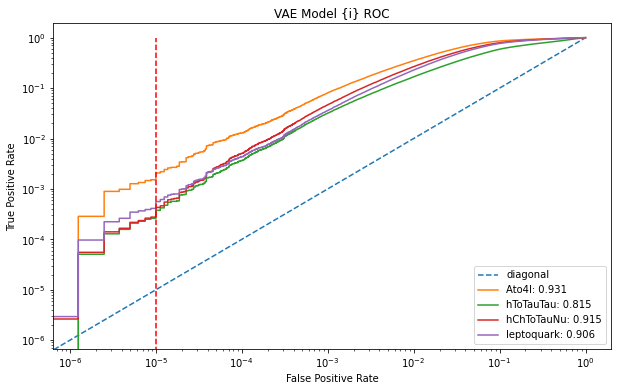


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001519
hToTauTau: 0.000262
hChToTauNu: 0.000276
leptoquark: 0.000411
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0015186978505958655), ('hToTauTau', 0.00026183198487450147), ('hChToTauNu', 0.0002762169328871772), ('leptoquark', 0.00041110693478669424)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_8/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1

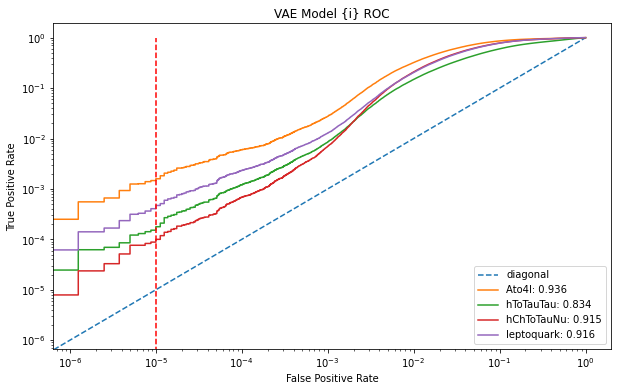


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001465
hToTauTau: 0.000152
hChToTauNu: 0.000088
leptoquark: 0.000405
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0014650967499865997), ('hToTauTau', 0.0001518914829382467), ('hChToTauNu', 8.812635477828988e-05), ('leptoquark', 0.00040523397857545576)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_9/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

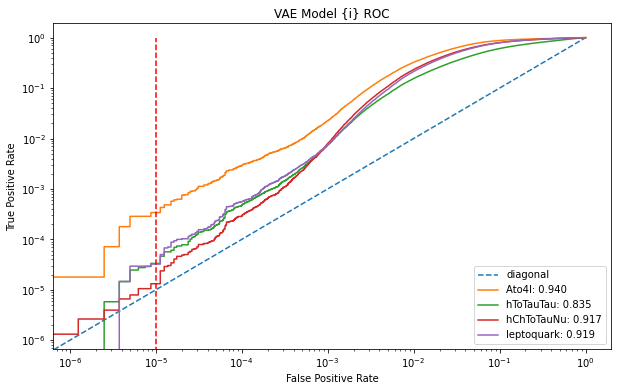


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000339
hToTauTau: 0.000033
hChToTauNu: 0.000013
leptoquark: 0.000032
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.000339473637192017), ('hToTauTau', 3.327146769123499e-05), ('hChToTauNu', 1.3153187280341772e-05), ('leptoquark', 3.230125916181169e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_10/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

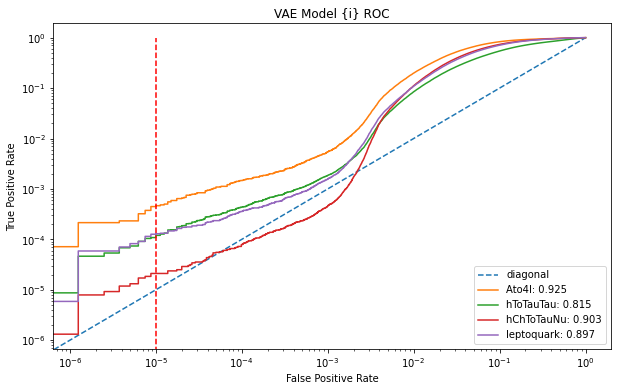


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000447
hToTauTau: 0.000108
hChToTauNu: 0.000018
leptoquark: 0.000126
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00044667583841054867), ('hToTauTau', 0.00010849391638446193), ('hChToTauNu', 1.841446219247848e-05), ('leptoquark', 0.00012626855854162752)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_11/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: 

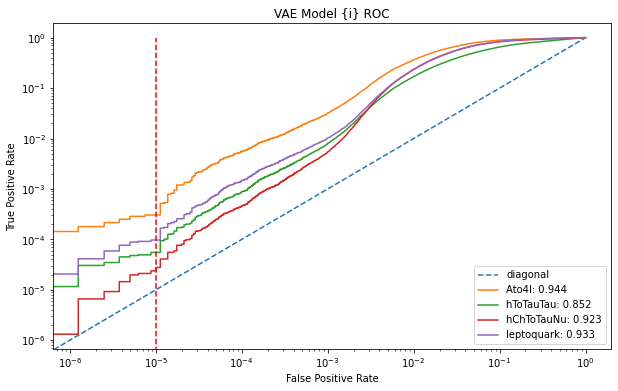


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000304
hToTauTau: 0.000055
hChToTauNu: 0.000024
leptoquark: 0.000097
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0003037395701191731), ('hToTauTau', 5.497025096812738e-05), ('hChToTauNu', 2.367573710461519e-05), ('leptoquark', 9.690377748543507e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_12/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

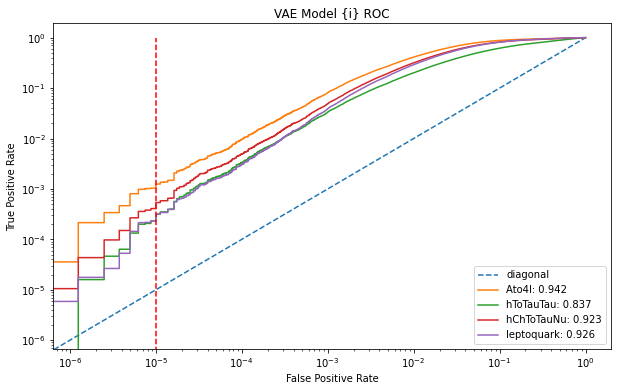


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001036
hToTauTau: 0.000231
hChToTauNu: 0.000408
leptoquark: 0.000232
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.001036287945112473), ('hToTauTau', 0.00023145368828685214), ('hChToTauNu', 0.00040774880569059496), ('leptoquark', 0.00023198177034392033)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_13/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (

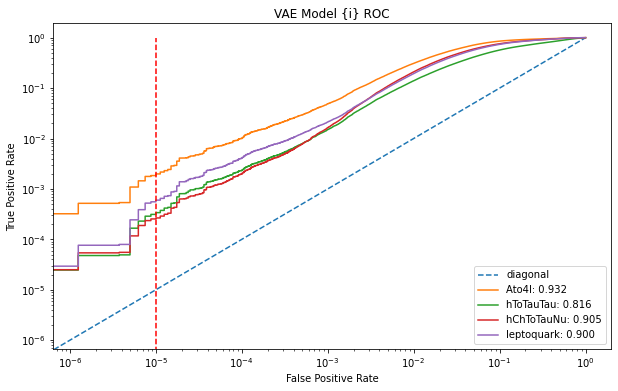


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001840
hToTauTau: 0.000312
hChToTauNu: 0.000254
leptoquark: 0.000555
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0018403044542514607), ('hToTauTau', 0.0003124624791872504), ('hChToTauNu', 0.0002538565145105962), ('leptoquark', 0.0005549943619620372)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_14/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

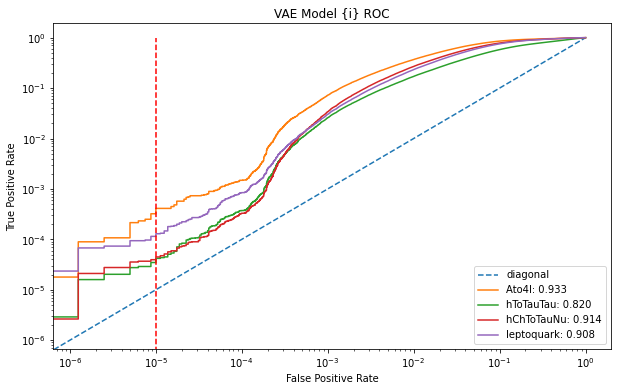


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000322
hToTauTau: 0.000035
hChToTauNu: 0.000039
leptoquark: 0.000115
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00032160660365559507), ('hToTauTau', 3.471805324302782e-05), ('hChToTauNu', 3.945956184102532e-05), ('leptoquark', 0.00011452264611915053)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_15/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (

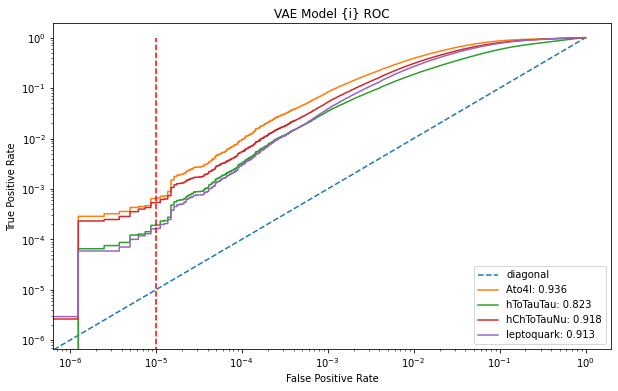


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000643
hToTauTau: 0.000190
hChToTauNu: 0.000534
leptoquark: 0.000162
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0006432132073111901), ('hToTauTau', 0.00018950270728486019), ('hChToTauNu', 0.000534019403581876), ('leptoquark', 0.00016150629580905844)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_16/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1

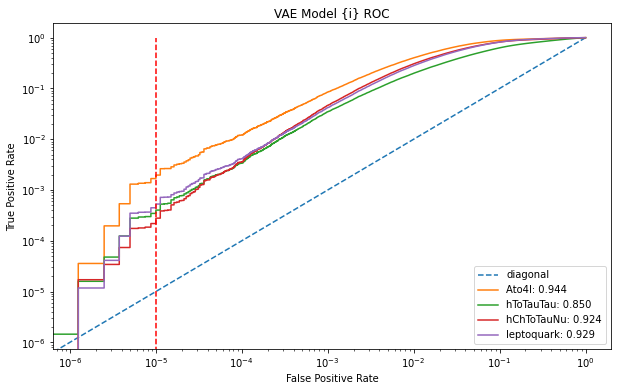


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001680
hToTauTau: 0.000346
hChToTauNu: 0.000218
leptoquark: 0.000446
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.001679501152423663), ('hToTauTau', 0.0003457339468784854), ('hChToTauNu', 0.00021834290885367342), ('leptoquark', 0.0004463446720541252)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_17/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

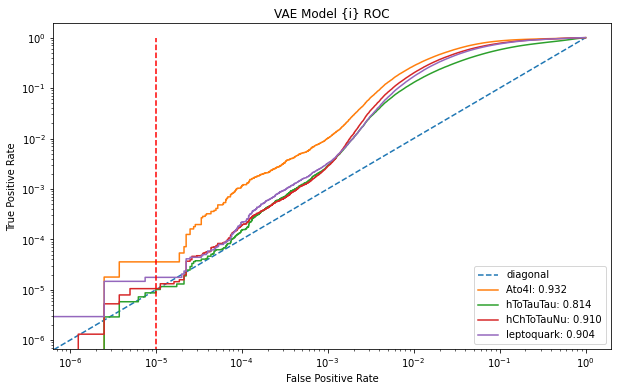


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000018
hToTauTau: 0.000009
hChToTauNu: 0.000011
leptoquark: 0.000015
Number of results: 4
GetPerformance() returned: [('Ato4l', 1.7867033536421948e-05), ('hToTauTau', 8.679513310756955e-06), ('hChToTauNu', 1.0522549824273418e-05), ('leptoquark', 1.4682390528096223e-05)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_18/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 20s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: 

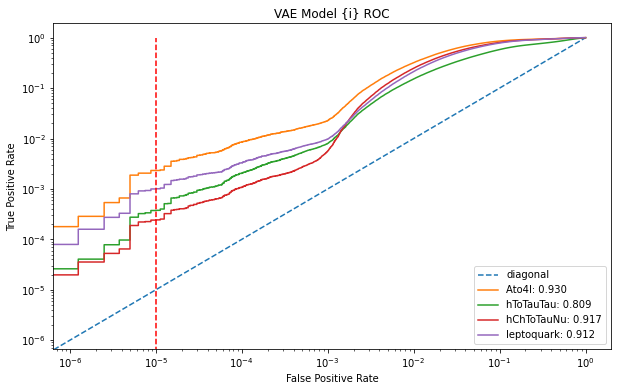


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002323
hToTauTau: 0.000373
hChToTauNu: 0.000241
leptoquark: 0.000998
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.002322714359734853), ('hToTauTau', 0.00037321907236254905), ('hChToTauNu', 0.00024070332723025444), ('leptoquark', 0.000998402555910543)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_19/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (14

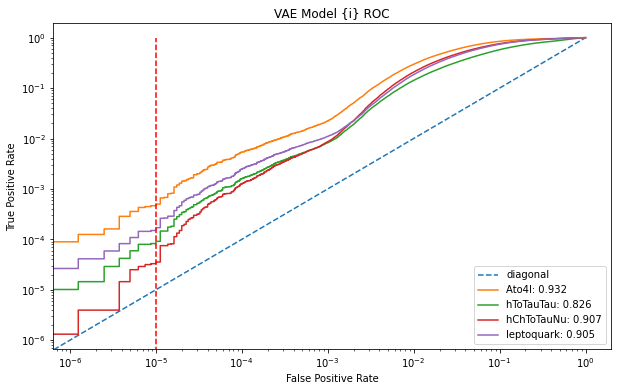


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.000465
hToTauTau: 0.000082
hChToTauNu: 0.000033
leptoquark: 0.000150
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00046454287194697065), ('hToTauTau', 8.245537645219107e-05), ('hChToTauNu', 3.288296820085443e-05), ('leptoquark', 0.00014976038338658146)]
Final channel results: {'Ato4l': [0.00044667583841054867, 0.0026800550304632922, 0.0016437670853508193, 0.000696814307920456, 0.002072575890224946, 0.00137576158230449, 0.00019653736890064142, 0.0015186978505958655, 0.0014650967499865997, 0.000339473637192017, 0.00044667583841054867, 0.0003037395701191731, 0.001036287945112473, 0.0018403044542514607, 0.00032160660365559507, 0.0006432132073111901, 0.001679501152423663, 1.7867033536421948e-05, 0.002322714359734853, 0.00046454287194697065], 'hToTauTau': [4.629073765737043e-05, 0.00030956930808366474, 0.0003298215058087643, 0.00010994050193625476, 0.0003457339468784854, 0.0001851629506294817, 8.824171865936238e-05, 0.00026183198

In [19]:
results = []
signal_names = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]
channel_results = {}
for i in range(20):
    try:
        model_path = f'/eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_{i}/'
        print(f"Evaluating model from path: {model_path}")
        evaluation = Model_Evaluator(model_path,
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model {i}',
                               save = False,
                               labels = signal_labels)
        
        print("Model_Evaluator instance created successfully")
        
        print("Calculating losses...")
        evaluation.calculate_loss('MSE')
        print("Losses calculated")
        
        print("Getting performance...")
        result = evaluation.GetPerformance()
        print(f"GetPerformance() returned: {result}")
        
        if not result:
            print(f"Warning: GetPerformance() returned an empty result for model {i}")
        else:
            for channel, tpr in result:
                if channel not in channel_results:
                    channel_results[channel] = []
                channel_results[channel].append(tpr)
    
    except Exception as e:
        print(f"An error occurred while evaluating model {i}:")
        print(traceback.format_exc())

print("Final channel results:", channel_results)

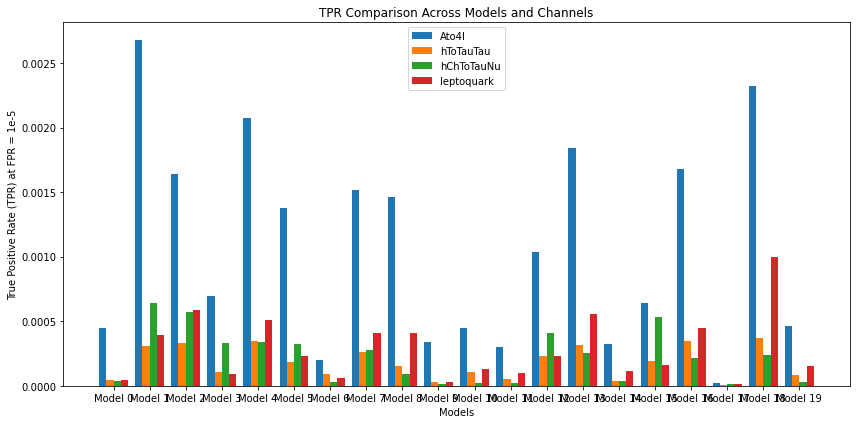


Channel Statistics:
Ato4l: Mean TPR = 0.0011, Std Dev = 0.0008
hToTauTau: Mean TPR = 0.0002, Std Dev = 0.0001
hChToTauNu: Mean TPR = 0.0002, Std Dev = 0.0002
leptoquark: Mean TPR = 0.0003, Std Dev = 0.0002


In [20]:
if channel_results:
    plt.figure(figsize=(12, 6))
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    x = np.arange(n_models)
    width = 0.8 / n_channels
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.bar(x + i * width, tprs, width, label=channel)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
    plt.legend()
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

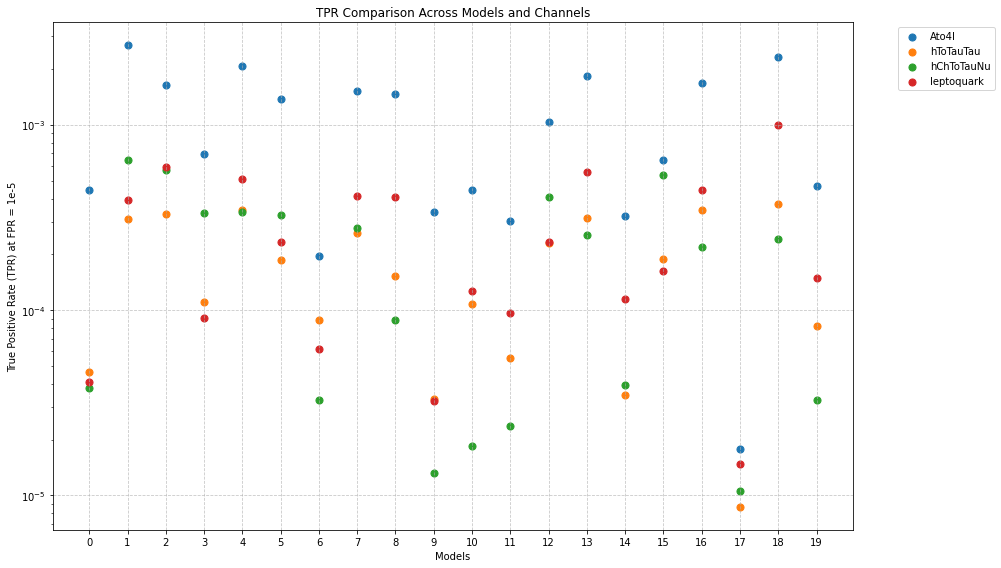


Channel Statistics:
Ato4l: Mean TPR = 0.0011, Std Dev = 0.0008
hToTauTau: Mean TPR = 0.0002, Std Dev = 0.0001
hChToTauNu: Mean TPR = 0.0002, Std Dev = 0.0002
leptoquark: Mean TPR = 0.0003, Std Dev = 0.0002


In [21]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

10642/10642 [==============================] - 20s 2ms/step


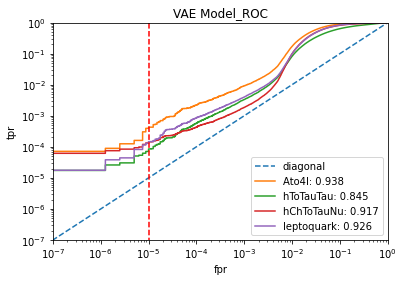


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.039307%, Theshold = 14.092132
hToTauTau: 0.007088%, Theshold = 14.092132
hChToTauNu: 0.013285%, Theshold = 14.092132
leptoquark: 0.012921%, Theshold = 14.092132


In [21]:
Losses=['MSE']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

10642/10642 [==============================] - 20s 2ms/step


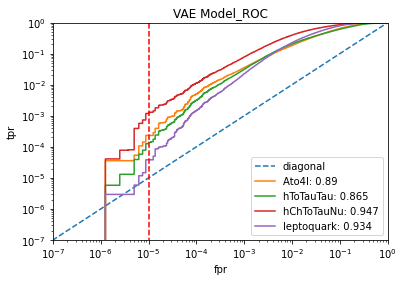


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.014294%, Theshold = 17.350264
hToTauTau: 0.012585%, Theshold = 15.724292
hChToTauNu: 0.117984%, Theshold = 15.724292
leptoquark: 0.001468%, Theshold = 17.350264


In [22]:
Losses=['KL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [18]:
print(Ato4l_data.shape)
print(hToTauTau_data.shape)
print(hChToTauNu_data.shape)
print(leptoquark_data.shape)

(55969, 57)
(691283, 57)
(760272, 57)
(340544, 57)


In [23]:
ori_vae_enc = Qmake_encoder_set_weights(57,32,16,3)
ori_vae_dec = Qmake_decoder_set_weights(57,32,16,3)
orginal_model = VAE_Model(ori_vae_enc, ori_vae_dec)
orginal_model.predict(Ato4l_data)
orginal_model.load_weights("/eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/small_2A_fixed_18/")


def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
    inputs = keras.Input(shape=(input_dim,), name='inputs')
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
    x = LeakyReLU(alpha=1/1024, name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense2")(x)    
    x = BatchNormalization(name="BN2")(x)
    x = LeakyReLU(alpha=1/1024, name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros())(x)
    new_encoder = keras.Model(inputs,z_mean,name='encoder')
    return new_encoder

1750/1750 [==============================] - 4s 2ms/step


In [24]:
orginal_model.predict(Ato4l_data)
tf.keras.models.save_model(orginal_model, 'VAE_40MHZ_model_Vsmall', save_format='tf')

1750/1750 [==============================] - 3s 2ms/step
INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall/assets


In [25]:
new_encoder = make_simplified_encoder(57,32,16,3)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.src.engine.input_layer.InputLayer object at 0x7f7fd0257850>
[]
set weight for  <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7fd026ac40>
[array([ 7.91028023e-01,  1.00000000e+00,  1.49675882e+00,  3.84356230e-01,
        1.22165585e+00,  9.72807944e-01,  1.10547388e+00,  3.42754722e-01,
        8.76597166e-01,  3.97605449e-01,  9.44894254e-02,  1.14141649e-03,
        4.96979147e-01,  3.49980369e-02,  1.93272263e-01,  5.30936778e-01,
        1.24722862e+00,  1.04817581e+00,  8.48624945e-01, -6.99940464e-03,
        5.40774941e-01,  7.04769909e-01, -1.11877725e-01,  5.04416525e-02,
        1.09973729e+00,  4.64642733e-01,  2.20921822e-02,  2.49517798e+00,
        3.01467240e-01,  1.36910605e+00,  3.70495558e+00,  1.19120848e+00,
        1.11952257e+00,  1.78361619e+00,  8.60098779e-01,  8.29567015e-01,
       -3.92940082e-02,  6.13323689e-01,  3.28495443e-01,  1.88979816e+00,
        5.28709412e-01,  2.76349962e-01,  1.362163

In [23]:
tf.keras.models.save_model(new_encoder, 'VAE_40MHZ_model_Vsmall', save_format='tf')

INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall/assets
